# **Caso práctico 2: Análisis de noticias**

## 1. Análisis de sentimiento

In [2]:
from datasets import load_dataset
from transformers import pipeline

import rubrix as rb

classifier = pipeline(
    "text-classification", 
    model="finiteautomata/beto-sentiment-analysis", 
    return_all_scores=True,
    truncation=True,
    padding=True
)

classifier = rb.monitor(classifier, dataset="noticias_en_es", sample_rate=1.0)

dataset = load_dataset("mlsum", "es", split="test[0:500]")

Reusing dataset mlsum (/Users/dani/.cache/huggingface/datasets/mlsum/es/1.0.0/77f23eb185781f439927ac2569ab1da1083195d8b2dab2b2f6bbe52feb600688)


In [4]:
dataset.map(
    lambda r: {"prediction": classifier(r["summary"])},
)

  0%|          | 0/500 [00:00<?, ?ex/s]

Dataset({
    features: ['date', 'summary', 'text', 'title', 'topic', 'url', 'prediction'],
    num_rows: 500
})

## 2. Categorización de texto (zero-shot)

In [ ]:
classifier = pipeline("zero-shot-classification", 
                       model="Recognai/zeroshot_selectra_medium")

labels = ["política", "cultura", "sociedad", "economia", "deportes", "ciencia y tecnología"]
template = "Esta noticia habla de {}."

In [ ]:
classifier = rb.monitor(classifier, dataset="noticias_en_es_categorias", sample_rate=1.0)

In [ ]:
dataset.map(
    lambda r: {"prediction": classifier(r["summary"], candidate_labels=labels, hypothesis_template=template)},
)

## 3. Categorización de texto (etiquetado programático usando weak supervision)

![Labeling workflow](https://raw.githubusercontent.com/recognai/rubrix-materials/main/tutorials/weak_supervision/weak_supervision.svg "Labeling workflow")

In [38]:
import pandas as pd

crisol = pd.read_csv("datos/crisol.csv", sep=";", names=["termino", "polaridad"]) ; crisol.head()

,termino,polaridad
0,abiertamente,positive
1,abrazo,positive
2,abrazos,positive
3,absorbente,positive
4,absorbentes,positive


<AxesSubplot:>

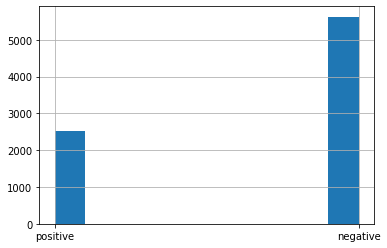

In [6]:
crisol.polaridad.hist()

In [7]:
crisol = crisol.sample(frac=1.0,)

In [8]:
from datasets import load_dataset

noticias = load_dataset("mlsum", "es", split="train[0:10000]")
records = [
    rb.TextClassificationRecord(
        inputs=noticia["summary"],
    )
    for noticia in noticias
] ; len(records)

10000

In [9]:
rb.delete(name="noticias_en_es_weak_supervision")
rb.log(records, name="noticias_en_es_weak_supervision")

BulkResponse(dataset='noticias_en_es_weak_supervision', processed=10000, failed=0)

In [14]:
from rubrix.labeling.text_classification import Rule, WeakLabels

terminos_positivos = crisol.query("polaridad == 'positive'")[0:500].values
terminos_negativos = crisol.query("polaridad == 'negative'")[0:500].values

In [15]:
for termino, polaridad in terminos_positivos:
    rules.append(
        Rule(query=f"{termino}", label="Positivo")
    )
    
    
for termino, polaridad in terminos_negativos:
    rules.append(
        Rule(query=f"{termino}", label="Negativo")
    )

In [ ]:
weak_labels = WeakLabels(rules=rules, dataset="noticias_en_es_weak_supervision")

In [18]:
weak_labels.summary()

,polarity,coverage,overlaps,conflicts
fenomenalmente,{},0.0000,0.0000,0.0000
primas,{Positivo},0.0005,0.0002,0.0000
perspicazmente,{},0.0000,0.0000,0.0000
caritativa,{},0.0000,0.0000,0.0000
adorado,{},0.0000,0.0000,0.0000
...,...,...,...,...
empedernido,{},0.0000,0.0000,0.0000
espinosa,{Negativo},0.0001,0.0000,0.0000
fealdad,{},0.0000,0.0000,0.0000
impias,{},0.0000,0.0000,0.0000


In [19]:
from snorkel.labeling.model import LabelModel

# train our label model
label_model = LabelModel()
label_model.fit(L_train=weak_labels.matrix(has_annotation=False))

# check its performance
#label_model.score(L=weak_labels.matrix(has_annotation=True), Y=weak_labels.annotation())

In [20]:
# Get the part of the weak label matrix that has no corresponding annotation
train_matrix = weak_labels.matrix(has_annotation=False)

# Get predictions from our label model
predictions = label_model.predict_proba(L=train_matrix)
predicted_labels = label_model.predict(L=train_matrix)

preds = [[('Positivo', pred[0]), ('Negativo', pred[1])] for pred in predictions]

# Get the records that do not have an annotation
train_records = weak_labels.records(has_annotation=False)

# Add the predictions to the records
def add_prediction(record, prediction):
    record.prediction = prediction
    return record

train_records_with_lm_prediction = [
    add_prediction(rec, pred)
    for rec, pred, label in zip(train_records, preds, predicted_labels)
    if label != weak_labels.label2int[None] # exclude records where the label model abstains
]

# Log a new dataset to Rubrix
rb.delete(name="noticias_en_es_snorkel")
rb.log(train_records_with_lm_prediction, name="noticias_en_es_snorkel")

BulkResponse(dataset='noticias_en_es_snorkel', processed=1411, failed=0)

## 4. Reconocimiento de entidades

In [27]:
import spacy
import rubrix as rb

from datasets import load_dataset

nlp = spacy.load("es_core_news_md")
nlp = rb.monitor(nlp, dataset="noticias_en_es_ner", sample_rate=1.0)

dataset = load_dataset("mlsum", "es", split="test[0:10000]")

In [37]:
def extract_entities(record):
    docs = nlp.pipe(record["summary"])
    return {"processed": [doc.text for doc in docs]}

dataset.map(
    extract_entities,
    batched=True, 
    batch_size=32
)

  0%|          | 0/313 [00:00<?, ?ba/s]

Dataset({
    features: ['date', 'processed', 'summary', 'text', 'title', 'topic', 'url'],
    num_rows: 10000
})

In [29]:
from rubrix.metrics.token_classification import *

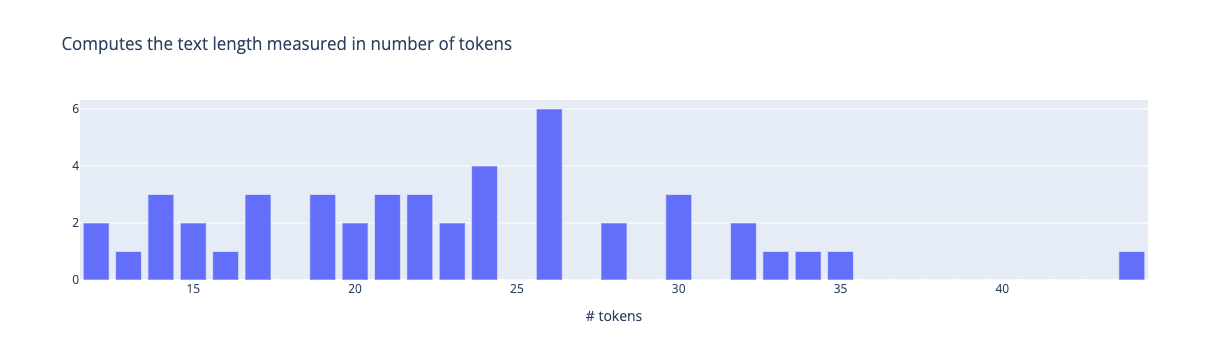

In [36]:
tokens_length(name="noticias_en_es_ner").visualize()